# Preparation 
## Importing libraries used in the project

In [148]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
# plt.style.use('seaborn-poster')
plt.style.use('seaborn')
import seaborn as sns
import numpy as np
%matplotlib inline
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

import scipy.stats as stats

from statsmodels.stats.power import TTestIndPower, TTestPower
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())# to pass in SQL queries in the form of a string to directly query our database.  

## Building tools for statistical testing and editing tables

### Welch's t-test
Use: To compare means between two samples
Assumption: Two populations represented by the two given samples have normal distributions. Two samples have unequal variances and sizes. If two samples have same sizes and equal variances, the result of the test will be identical to student's t-test.

In [149]:
def welch_t(exp, cont):
    
    """ Calculate Welch's t statistic for two samples. """

    numerator = exp.mean() - cont.mean()
    
    # “ddof = Delta Degrees of Freedom”: the divisor used in the calculation is N - ddof, 
    #  where N represents the number of elements. By default ddof is zero.
    
    denominator = np.sqrt(exp.var(ddof=1)/exp.size + cont.var(ddof=1)/cont.size)
    
    return np.abs(numerator/denominator)

def welch_df(exp, cont):
    
    """ Calculate the effective degrees of freedom for two samples. This function returns the degrees of freedom """
    
    s1 = exp.var(ddof=1) 
    s2 = cont.var(ddof=1)
    n1 = exp.size
    n2 = cont.size
    
    numerator = (s1/n1 + s2/n2)**2
    denominator = (s1/ n1)**2/(n1 - 1) + (s2/ n2)**2/(n2 - 1)
    
    return numerator/denominator


def p_value_welch_ttest(exp, cont, two_sided=False):
    """Calculates the p-value for Welch's t-test given two samples.
    By default, the returned p-value is for a one-sided t-test. 
    Set the two-sided parameter to True if you wish to perform a two-sided t-test instead.
    """
    t = welch_t(exp, cont)
    df = welch_df(exp, cont)
    
    p = 1-stats.t.cdf(np.abs(t), df)
    
    if two_sided:
        return 2*p
    else:
        return p

In [150]:
def welch_summary(dict_dfs,measurement, alpha =0.05,two_sided=False):
    """
        The function 
        takes :
        dic_dfs ={group1: pandas.Series, group2:pandas.Series }
            note: group1 is the experimental group and group2 is the control group.
        mesurement = string to describe what we compare
        alpah (optional, significance level)
        two_sided(optional, choosing two tail (True) or one tail(False, default))
        
        prints information to compare two groups using welch's t-test:
        median values,
        mean values,
        sample sizes, 
        welch's t-test p-value
        conclusion of the test result 
        Cohen's d for effect size (if the difference of mean values of two 
        groups is significant) 
        
        returns:
        p value if the null hypothesis fails to be rejected
        (p value, Cohen's D) if the null hypothesis is rejected
        """
    names = list(dict_dfs.keys())
    data = list(dict_dfs.values())
    n1 = names[0]
    n2 = names[1]
    a = data[0]
    b = data[1]
    print(f'Comparison of the average of {measurement} for {n1} and {n2}')
    print(f'Median Values: \t{n1}:{round(a.median(),2)}', 
          f'\t{n2}:{round(b.median(),2)}')
    print(f'Mean Values: \t{n1}:{round(a.mean(),2)}',
          f'\t{n2}:{round(b.mean(),2)}')
    print(f'Sample sizes: \t{n1}:{len(a)}', 
          f'\t{n2}:{len(b)}')
    print("\n")
    print(f"Welch's t-test p-value:{round(p_value_welch_ttest(a,b),5)}")
    if p_value_welch_ttest(a,b, two_sided)< alpha:
        print(f"Test result:\tThere is statistically significant difference \n",
                 f"\t\tbetween the means of two groups with {(1-alpha)*100}% confidence level.")
        print(f"Effect size:\t{round(Cohen_d(a,b),2)}")
        print(f"Level of effect size:\t{cohen_level(round(Cohen_d(a,b),2))}\n\n")
        return(round(p_value_welch_ttest(a,b),5), round(Cohen_d(a,b),2))
    else:
        print(f"Test result:\tThe differenc in mean values between two groups is\n",
             f"\t\tstatistically insignificant with {alpha*100}% significance level.\n\n")
        return(round(p_value_welch_ttest(a,b),5))


### ANOVA test
Use: To test significance of differences between mean values of multiple groups

In [151]:
def anova_oneway_summary(dict_dfs,measurement, f_test_p ,alpha =0.05):
    """
        The function 
        takes :
        dic_dfs ={group1: pandas.Series, group2:pandas.Series,... }
            note: group1 is the experimental group and group2 is the control group.
        mesurement = string to describe what we compare
        f_test_p = stats.f_oneway(data1,data2,...)[1]
        alpah (optional, significance level)
        two_sided(optional, choosing two tail (True) or one tail(False, default))
        
        prints information to compare two groups using welch's t-test:
        median values,
        mean values,
        sample sizes, 
        welch's t-test p-value
        conclusion of the test result 
        Cohen's d for effect size (if the difference of mean values of two 
        groups is significant) 
        
        returns:
        p value if the null hypothesis fails to be rejected
        (p value, Cohen's D) if the null hypothesis is rejected
        """
    names = list(dict_dfs.keys())
    data = list(dict_dfs.values())
    phrases =[]
    for i in range(len(names)):
        if i <len(names)-1:
            phrases.append(str(names[i])+', ')
        else:
            phrases.append('and '+ str(names[i]))
    phrase1 = f'Comparison of the averages of {measurement} for'
    phrase2=f'Median Values:'
    phrase3= f'Mean Values:'
    phrase4=f'Sample sizes:'
    for i in range(len(names)):
        if i <len(names)-1:
            phrase1 += ' '+ str(names[i])+','
            phrase2 += f'\t{names[i]}:{round(data[i].median(),2)}'
            phrase3 += f'\t{names[i]}:{round(data[i].mean(),2)}'
            phrase4 += f'\t{names[i]}:{len(data[i])}'
        else:
            phrase1 += ' and '+ str(names[i])+'.'
            phrase2 += f'\t{names[i]}:{round(data[i].median(),2)}'
            phrase3 += f'\t{names[i]}:{round(data[i].mean(),2)}'
            phrase4 += f'\t{names[i]}:{len(data[i])}'
    print(phrase1)
    print(phrase2)
    print(phrase3)
    print(phrase4)
    print("\n")
    print(f"ANOVA test p-value:{round(f_test_p,5)}")
    if f_test_p < alpha:
        print(f"Test result:\tThere is statistically significant difference \n",
                 f"\t\tbetween the means of two groups with {(1-alpha)*100}% confidence level.")
        return(round(f_test_p,5))
    else:
        print(f"Test result:\tThe differenc in mean values between groups is\n",
             f"\t\tstatistically insignificant with {alpha*100}% significance level.")
        return(round(f_test_p,5))


### Cohen's d (effect size)
Use: To indicate the level of difference between comparing sets. It also can be used for a power analysis.

In [152]:
def Cohen_d(exp, cont):

    """
    Compute Cohen's d
    
    takes:
    exp: Series or NumPy array
    cont: Series or NumPy array

    returns:
    Cohen's d as a floating point number 
    """
    diff = exp.mean() - cont.mean()

    n1, n2 = len(exp), len(cont)
    var1 = exp.var()
    var2 = cont.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [153]:
def cohen_level(a):
    """
        Provide the level of Cohen's d
        takes: Cohen's d
        returns: level of the effect size"""
    if a<0.2:
        return('very small')
    elif 0.2<= a <0.5:
        return('small')
    elif 0.5<= a<0.8:
        return('medium')
    else:
        return('large')
        

### Renaming identically named columns after joins for pandas.DataFrames

In [154]:
# if len(df.columns) !=len(set(df.columns)):
def rename_dup_columns(df):
    '''
    Takes a dataframe and check if its column has identical names. 
    Then if there are,return the column names and number of identical columns, 
    and an array of updated column names.
    
    For example, if there are 2 columns with name 'Id':
    * it will print "There are 2 columns with name: Id "
    * it will keep first column name as it is and the second column name as Id.1 
        and return the updated array of column names. 
    '''
    cols = pd.Series(df.columns)

    if len(df.columns.get_duplicates())>0:
        for dup in df.columns.get_duplicates():
            print(f"There are {df.columns.get_loc(dup).sum()} columns with name:{dup}")
            #df.columns.get_loc(dup) is an np.array not a list which makes it possible to do follwing
            cols[df.columns.get_loc(dup)] =np.array([dup + '_' + str(d_idx) 
                                             if d_idx != 0 
                                             else dup 
                                             for d_idx in range(df.columns.get_loc(dup).sum())])
        return cols        
    else:
        return "There is not identically named columns in the dataframe"
        

### Importing each tables in the Northwind database as a dictionary

In [155]:
#Build a connection to the database
conn = sqlite3.connect('Northwind_small.sqlite')
c= conn.cursor()

In [156]:
#Save table names 
table_names = [x[0] for x in c.execute("SELECT name from sqlite_master WHERE type ='table';").fetchall()]
table_names

['Employee',
 'Category',
 'Customer',
 'Shipper',
 'Supplier',
 'Order',
 'Product',
 'OrderDetail',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Region',
 'Territory',
 'EmployeeTerritory']

In [157]:
#Make a dictionary with 
#key:table name
#value: table as a pd.DataFrame
df_tables ={}
for name in table_names:
    #'Order' is a reserved keyword in SQL so we put [] to use it as table name
    if name == 'Order':
        query =f"SELECT * from [{name}]"
        df_tables[name]=pd.read_sql(query,conn)
    else:
        query =f"SELECT * from {name}"
        df_tables[name]=pd.read_sql(query,conn)

# EDA: Sales  influenced by different factors

In [158]:
"""Join Products/Order/OrderDetail/Category"""
query = """SELECT * 
            FROM Product AS p 
            LEFT JOIN OrderDetail AS od
            ON (p.Id = od.ProductId)
            JOIN Category as c 
            on (p.CategoryID = c.Id)
            JOIN [Order] as o 
            ON (o.Id = od.OrderId);"""
df = pd.read_sql(query, conn)

In [159]:
#Renaming identical column names by numbering
df.columns = rename_dup_columns(df)

There are 4 columns with name:Id
There are 2 columns with name:UnitPrice


C:\Users\woogu\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  from ipykernel import kernelapp as app
C:\Users\woogu\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  app.launch_new_instance()


In [160]:
rename_dup_columns(df)

C:\Users\woogu\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  from ipykernel import kernelapp as app


'There is not identically named columns in the dataframe'

In [161]:
#Creating new feature for total price per order
df.eval("Price_total = UnitPrice*Quantity ",inplace = True)

In [162]:
#Year the order was placed
df['Year_Order']=[int(x[:4]) for x in df.OrderDate]

## Total number of orders made in each year

C:\Users\woogu\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


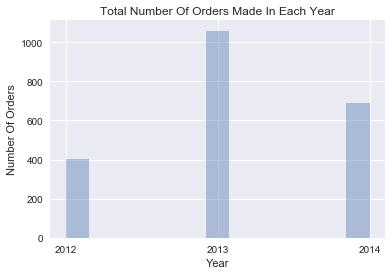

In [163]:
sns.distplot(df['Year_Order'], kde = False)
plt.xticks([2012,2013,2014])
plt.ylabel('number of orders'.title())
plt.xlabel('Year'.title())
plt.title('Total number of orders made in each year'.title())
plt.show()

Since number or orders may not reflect the total revenue as the quantity per order may 
make up for the decrease in number of order, we plot the total revenue by year.

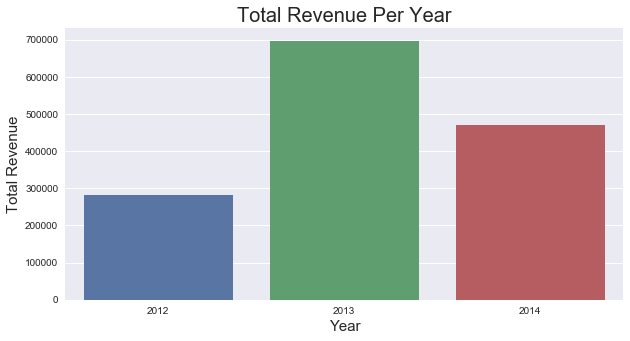

In [164]:
TotalSales_Year = []

for i, year in enumerate(df.Year_Order.unique()):
    TotalSales_Year.append(sum(df[df.Year_Order == year].Price_total)) 
fig = plt.figure(figsize =(10,5))
sns_plot = sns.barplot(x=['2012', '2013','2014'],y=TotalSales_Year)

plt.title('Total revenue per year'.title(), fontsize =20)
plt.xlabel('year'.title(), fontsize =15)
plt.ylabel('Total revenue'.title(), fontsize =15)
plt.rc('ytick', labelsize =15)
plt.show()
fig1 = sns_plot.get_figure() 
# fig1.savefig('year_totalRev.png', dpi=400, bbox_inches="tight") #Saving fig
# fig.savefig('year_totalRev.png', dpi=400, bbox_inches="tight")#saving fig


## Total number of orders sorted by categories

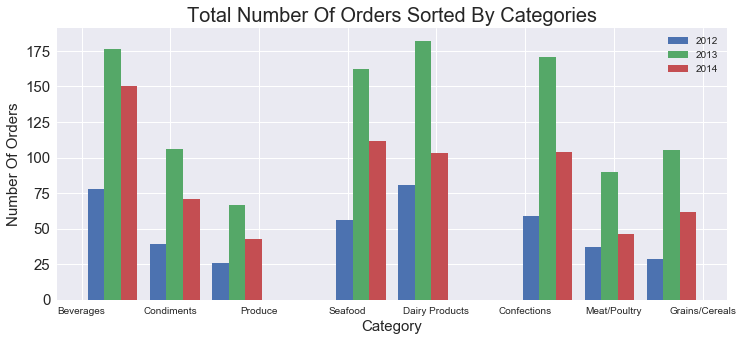

In [165]:
Orders_by_Year = []

for i, year in enumerate(df.Year_Order.unique()):
    Orders_by_Year.append(df[df.Year_Order == year].CategoryName) 
fig = plt.figure(figsize =(12,5))
plt.hist(Orders_by_Year, label =['2012', '2013','2014'])
plt.ylabel('number of orders'.title(), fontsize =15)
plt.xlabel('category'.title(), fontsize =15)
plt.rc('xtick', labelsize = 13)
plt.rc('ytick', labelsize = 15)
plt.title('Total number of orders sorted by categories'.title(), fontsize =20)
plt.legend()
plt.show()
# fig.savefig('year_category.png', dpi=400, bbox_inches="tight")#saving fig

## Difference between total sales in categories by  year

* Sales sorted by year of the order date and category of the product

In [166]:
#Sales sorted by year of the order date and category of the product
q ="""SELECT   Year_Order,
            CategoryName, 
            COUNT(OrderId) as order_counts, 
            SUM(Quantity) as total_units,
            SUM(Price_total) as sales_revenue
    FROM df
    GROUP BY Year_Order, CategoryName
    ORDER BY sales_revenue"""
category_sale = pysqldf(q)
category_sale.head()

,Year_Order,CategoryName,order_counts,total_units,sales_revenue
0,2012,Grains/Cereals,29,549,12289.50
1,2012,Produce,26,549,18931.25
2,2012,Condiments,39,962,24356.60
3,2012,Seafood,56,1286,26997.23
4,2014,Grains/Cereals,62,1377,30422.25


* Divide the table by year

In [167]:
c12 = category_sale[category_sale.Year_Order == 2012]
c13 = category_sale[category_sale.Year_Order == 2013]
c14 = category_sale[category_sale.Year_Order == 2014]

* Calculate the changes by year per each category

<Figure size 1440x360 with 0 Axes>

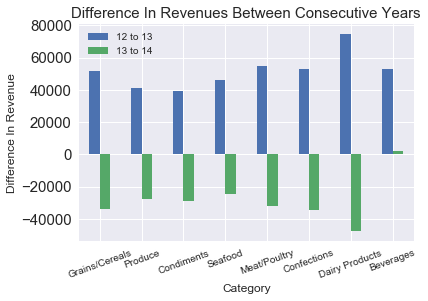

In [168]:
#merge the tables divided by year
category_sum = c12.set_index('CategoryName')\
                .join(c13.set_index('CategoryName'),lsuffix='_12', rsuffix='_13')\
                .join(c14.set_index('CategoryName'), rsuffix='_14')

#calculate the difference in sales between consecutive years
category_sum.eval('sales_revenue_12_to_13 = sales_revenue_13 - sales_revenue_12 ', inplace =True )
category_sum.eval('sales_revenue_13_to_14 = sales_revenue - sales_revenue_13 ', inplace =True )

change =pd.DataFrame( {'12 to 13': category_sum.sales_revenue_12_to_13,
                       '13 to 14': category_sum.sales_revenue_13_to_14})

fig = plt.figure(figsize=(20,5))

change.plot.bar(rot=90)
plt.title('Difference in revenues between consecutive years'.title(),fontsize =15)
plt.ylabel('difference in revenue'.title(), fontsize =12)
plt.xlabel('Category', fontsize =12)
plt.rc('ytick',labelsize = 10)
# plt.rc('xtick',labelsize = 13)
plt.xticks(fontsize =10, rotation = 20)
plt.show()

fig.savefig('Diff_rev.png', dpi=400, bbox_inches="tight")#saving fig

We can see that except beverages, most categories have increase then decrease in sales. 
Now we want to investigate difference factor that may have influenced these changes. 

# The total spending per order 
Conducting ANOVA test 

$H_0$ : The average of total spending per order in year 2012, 2013, and 2014 ($\mu_{2012}$, $\mu_{2013}$, $\mu_{2014}$) has not changed.

$$ \large\mu_{2012} = \mu_{2013} = \mu_{2014}$$

$H_a$ : The averages of total spending per order are different from one year to the others (at least one of them is different from the other two averages). 


2012 Total spending per order
count      152.000000
mean      1862.137171
std       2121.815144
min         60.000000
25%        559.750000
50%       1319.550000
75%       2456.062500
max      15353.600000
Name: Price_total, dtype: float64 

2013 Total spending per order
count      408.000000
mean      1707.233137
std       1914.725381
min         12.500000
25%        518.600000
50%       1182.600000
75%       2214.187500
max      14366.500000
Name: Price_total, dtype: float64 

2014 Total spending per order
count      270.000000
mean      1739.893852
std       2427.355997
min         30.000000
25%        508.500000
50%        932.025000
75%       1959.107500
max      17250.000000
Name: Price_total, dtype: float64 



C:\Users\woogu\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


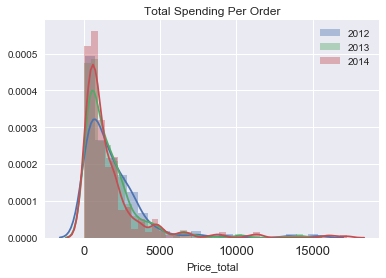

In [169]:
''' do people spend less money per order?
    1)Divide df by years
    2)Collect by order using OrderId
    3)check for outliers
    4)conduct Welch's ttest
    '''

Orders_by_Year ={}
Total_per_Order =[]
for i, year in enumerate(df.Year_Order.unique()):
    Orders_by_Year[year] = df[df.Year_Order == year]
    Total_per_Order.append(Orders_by_Year[year].groupby('OrderId').Price_total.sum())
    print(year,'Total spending per order')
    print(Total_per_Order[i].describe(),'\n')
    sns_plot =sns.distplot(Total_per_Order[i], label = str(year))
plt.legend()
plt.title('Total spending per order'.title())
plt.show()
# fig1 = sns_plot.get_figure() 
# fig1.savefig('spending_order_kde.png', dpi=400, bbox_inches="tight") #Saving fig

In [170]:

#Investigate Percentiles to find outliers 
for q in np.linspace(0.8,1,num=21):
    q2012 = round(Total_per_Order[0].quantile(q=q),2)
    q2013 = round(Total_per_Order[1].quantile(q=q),2)
    q2014 = round(Total_per_Order[2].quantile(q=q),2)
    print('{}th percentile:\t2012:{}\t2013:{}\t2014:{}'.format(round(q,2), q2012, q2013,q2014 ))

0.8th percentile:	2012:2839.33	2013:2496.75	2014:2236.04
0.81th percentile:	2012:2854.75	2013:2558.35	2014:2352.68
0.82th percentile:	2012:2903.88	2013:2625.23	2014:2429.17
0.83th percentile:	2012:2974.91	2013:2712.4	2014:2631.75
0.84th percentile:	2012:3087.34	2013:2763.18	2014:2737.78
0.85th percentile:	2012:3131.17	2013:2827.11	2014:2835.7
0.86th percentile:	2012:3178.46	2013:2942.18	2014:2977.4
0.87th percentile:	2012:3273.51	2013:3121.33	2014:3108.1
0.88th percentile:	2012:3416.26	2013:3359.5	2014:3514.05
0.89th percentile:	2012:3556.28	2013:3432.97	2014:3612.7
0.9th percentile:	2012:3622.88	2013:3626.4	2014:3743.2
0.91th percentile:	2012:3707.1	2013:3908.79	2014:4345.77
0.92th percentile:	2012:3898.5	2013:4163.23	2014:4689.64
0.93th percentile:	2012:4219.36	2013:4331.61	2014:4776.57
0.94th percentile:	2012:4557.69	2013:4609.34	2014:4927.15
0.95th percentile:	2012:4832.37	2013:4832.81	2014:5866.64
0.96th percentile:	2012:5190.96	2013:5193.64	2014:6580.71
0.97th percentile:	2012:65

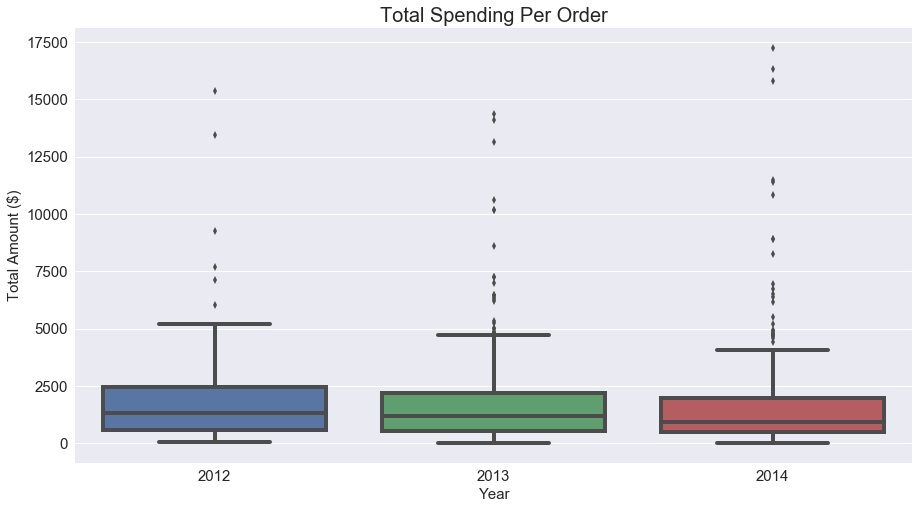

In [219]:
data =[]
data += [(2012, o) for o in Total_per_Order[0]]
data += [(2013, o) for o in Total_per_Order[1]]
data += [(2014, o) for o in Total_per_Order[2]]


# test[2013]=Total_per_Order[1].reset_index()
# test[2014]=Total_per_Order[2].reset_index()
data =pd.DataFrame(data)
data.columns =['Year','Total_Spending']

fig, ax = plt.subplots(figsize=(15,8))

sns.boxplot(
    y="Total_Spending", 
    x="Year", 
    data=data,
    linewidth =4,
    ax=ax,
#     color='aqua',
#     inner="quartile",  # Seeing the mean and quariles
#     bw=.3              # How much smoothing do we usec
)

# sns_plot = sns.swarmplot(ax=ax, x="Year", y="Total_Spending", data=data, color ='orange', alpha=0.5, size=5)
plt.ylabel('Total Amount ($)'.title(), fontsize =15)
plt.xlabel('Year', fontsize =15)
plt.title('Total spending per order'.title(), fontsize =20)
ax.tick_params(axis='both', which='major', labelsize=15)
#saving figure as image
# fig.savefig('box_totalspending.png', dpi=400, bbox_inches="tight")

In [220]:
compare ={}
compare[2012] = Total_per_Order[0]
compare[2013] = Total_per_Order[1]
compare[2014]= Total_per_Order[2]
# Orders_by_Year 
anova_oneway_summary(compare,'total spending per order',stats.f_oneway(Total_per_Order[0],Total_per_Order[1],Total_per_Order[2])[1])

Comparison of the averages of total spending per order for 2012, 2013, and 2014.
Median Values:	2012:1319.55	2013:1182.6	2014:932.02
Mean Values:	2012:1862.14	2013:1707.23	2014:1739.89
Sample sizes:	2012:152	2013:408	2014:270


ANOVA test p-value:0.74518
Test result:	The differenc in mean values between groups is
 		statistically insignificant with 5.0% significance level.


0.74518

Using $\alpha = 0.05$, we fail to reject both null hypotheses. That means, we can't find enough evidence to conclude that there were significant change in how each customer spent per order for those three years.  

So far, we see that the total number of sales had increased from 2012 to 2013 then decreased from 2013 to 2014 and it was also consistent in sales by categories. 

However, we couldn't find enough evidence that changes in the average spending per order was significant.


# Quantity per Order by years

Conducting ANOVA test 

$H_0$ : The average of quantity per order in year 2012, 2013, and 2014 ($\mu_{2012}$, $\mu_{2013}$, $\mu_{2014}$) has not changed.

$$ \large\mu_{2012} = \mu_{2013} = \mu_{2014}$$

$H_a$ : The averages of quantity per order are different from one year to the others (at least one of them is different from the other two averages). 


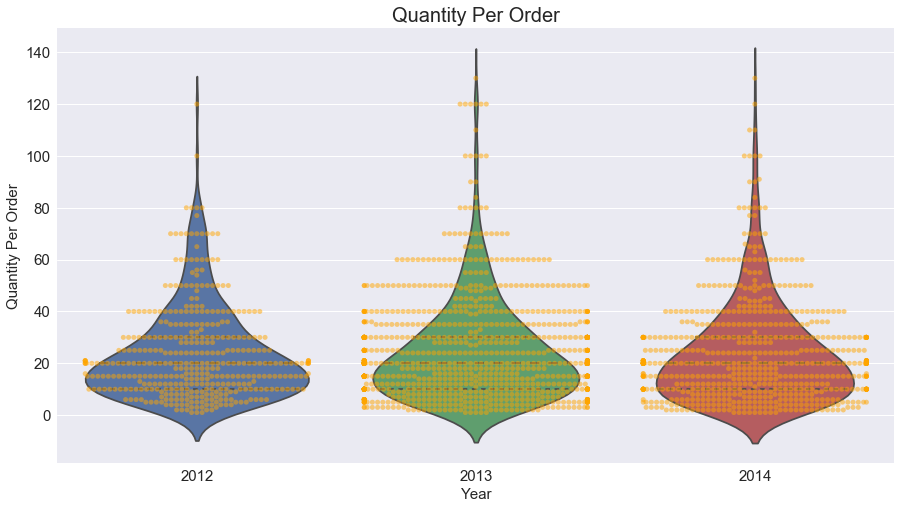

In [221]:
data =[]
data += [(2012, o) for o in df.loc[df.Year_Order==2012].Quantity]
data += [(2013, o) for o in df.loc[df.Year_Order==2013].Quantity]
data += [(2014, o) for o in df.loc[df.Year_Order==2014].Quantity]


# test[2013]=Total_per_Order[1].reset_index()
# test[2014]=Total_per_Order[2].reset_index()
data =pd.DataFrame(data)
data.columns =['Year','Quantity']

fig, ax = plt.subplots(figsize=(15,8))

sns.violinplot(
    y="Quantity", 
    x="Year", 
    data=data, 
    ax=ax,
#     color='aqua',
    inner="quartile",  # Seeing the mean and quariles
    bw=.3              # How much smoothing do we usec
)

sns_plot = sns.swarmplot(ax=ax, x="Year", y="Quantity", data=data, color ='orange', alpha=0.5, size=5)
plt.ylabel('Quantity per order'.title(), fontsize =15)
plt.xlabel('Year', fontsize =15)
plt.title('quantity per order'.title(), fontsize =20)
ax.tick_params(axis='both', which='major', labelsize=15)
#saving figure as image
# fig1 = sns_plot.get_figure()
# fig.savefig('violin_quantity.png', dpi=400, bbox_inches="tight")

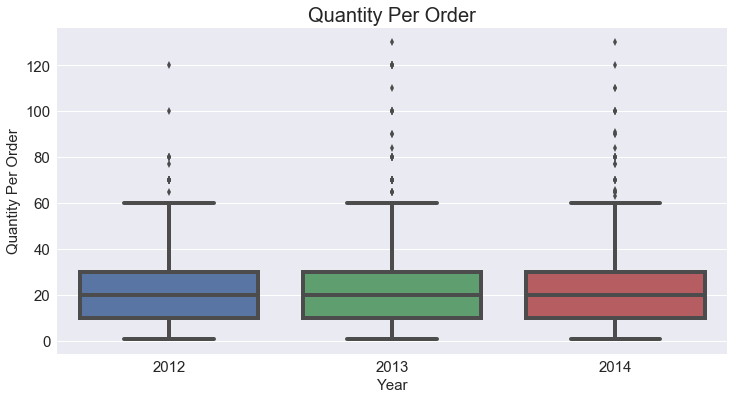

In [222]:
fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(
    y="Quantity", 
    x="Year", 
    data=data, 
    ax=ax,
    #color='aqua',
    linewidth = 4, 
)

plt.ylabel('Quantity per order'.title(), fontsize =15)
plt.xlabel('Year', fontsize =15)
plt.title('quantity per order'.title(), fontsize =20)
ax.tick_params(axis='both', which='major', labelsize=15)
#saving figure as image
# fig1 = sns_plot.get_figure()
# fig.savefig('box_quantity.png', dpi=400, bbox_inches="tight")

In [223]:

a=list(df.loc[df.Year_Order==2012].Quantity)
b=list(df.loc[df.Year_Order==2013].Quantity)
c=list(df.loc[df.Year_Order==2014].Quantity)
compare = {2012:df.loc[df.Year_Order==2012].Quantity,
          2013:df.loc[df.Year_Order==2013].Quantity,
          2014:df.loc[df.Year_Order==2014].Quantity}
measurement =' average quantity per order in year'
f = stats.f_oneway(a,b,c)[1]
anova_oneway_summary(compare,measurement, f,alpha =0.05)

Comparison of the averages of  average quantity per order in year for 2012, 2013, and 2014.
Median Values:	2012:20.0	2013:20.0	2014:20.0
Mean Values:	2012:23.66	2013:24.07	2014:23.51
Sample sizes:	2012:405	2013:1059	2014:691


ANOVA test p-value:0.82227
Test result:	The differenc in mean values between groups is
 		statistically insignificant with 5.0% significance level.


0.82227

# Customer retention rate

Let us investigate the retention rate for customers. 
Divide `CustomerId` into three groups by year in their order history using `OrderDate`. 

In [176]:
query ="""
            SELECT CustomerId, 
                    Year_Order,
                    COUNT(DISTINCT(OrderId)) as Order_Counts,
                    SUM(Price_total) as Total$
            FROM df
            GROUP BY 1,2
            """
customers = pysqldf(query)
customers.head()
# df.groupby(['CustomerId','Year_Order']).OrderId.count()

,CustomerId,Year_Order,Order_Counts,Total$
0,ALFKI,2013,3,2294.00
1,ALFKI,2014,3,2302.20
2,ANATR,2012,1,111.00
3,ANATR,2013,2,799.75
4,ANATR,2014,1,514.40


In [177]:
c12 = customers.query('Year_Order == 2012')
c13 = customers.query('Year_Order == 2013')
c14 = customers.query('Year_Order == 2014')
q = """SELECT * 
        FROM c14 
        LEFT JOIN c13 USING(CustomerId)
        LEFT JOIN c12 using(CustomerId)"""
customer_history = pysqldf(q)
customer_history.columns = rename_dup_columns(customer_history)
customer_history.head()

There are 3 columns with name:Year_Order
There are 3 columns with name:Order_Counts
There are 3 columns with name:Total$


C:\Users\woogu\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  from ipykernel import kernelapp as app
C:\Users\woogu\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  app.launch_new_instance()


,CustomerId,Year_Order,Order_Counts,Total$,Year_Order_1,Order_Counts_1,Total$_1,Year_Order_2,Order_Counts_2,Total$_2
0,ALFKI,2014,3,2302.20,2013.0,3.0,2294.00,NaN,NaN,NaN
1,ANATR,2014,1,514.40,2013.0,2.0,799.75,2012.0,1.0,111.00
2,ANTO,2014,1,660.00,2013.0,5.0,6452.15,2012.0,1.0,504.00
3,AROUT,2014,4,5838.50,2013.0,7.0,6702.25,2012.0,2.0,1723.75
4,BERGS,2014,5,8110.55,2013.0,10.0,14838.30,2012.0,3.0,5406.90


In [178]:
customer_history.Year_Order_1.fillna(2013, inplace =True)
customer_history.Order_Counts_1.fillna(0,inplace =True)
customer_history['Total$_1'].fillna(0,inplace = True)
customer_history.Year_Order_2.fillna(2012, inplace =True)
customer_history.Order_Counts_2.fillna(0,inplace =True)
customer_history['Total$_2'].fillna(0,inplace = True)

In [179]:
customer_history.describe()

,Year_Order,Order_Counts,Total$,Year_Order_1,Order_Counts_1,Total$_1,Year_Order_2,Order_Counts_2,Total$_2
count,81.0,81.000000,81.000000,81.0,81.000000,81.000000,81.0,81.000000,81.000000
mean,2014.0,3.333333,5799.646173,2013.0,4.691358,8002.248395,2012.0,1.728395,3335.295062
std,0.0,2.207940,8925.907057,0.0,3.231261,11891.984784,0.0,1.573311,4780.881599
min,2014.0,1.000000,45.000000,2013.0,0.000000,0.000000,2012.0,0.000000,0.000000
25%,2014.0,1.000000,1117.000000,2013.0,2.000000,1410.000000,2012.0,1.000000,111.000000
50%,2014.0,3.000000,2371.000000,2013.0,4.000000,5217.650000,2012.0,1.000000,1450.000000
75%,2014.0,4.000000,5994.060000,2013.0,6.000000,9860.450000,2012.0,3.000000,4269.400000
max,2014.0,11.000000,42806.250000,2013.0,17.000000,65762.450000,2012.0,6.000000,21487.760000


Number of new customer in 2014 (no order history in 2012 and 2013)

In [180]:
new_2014 = customer_history.query('Order_Counts_2 ==0 &Order_Counts_1 ==0 ')
print(f'There are {len(new_2014)} new customers in 2014.')

There are 1 new customers in 2014.


Number of new customer in 2013 (no order history in 2012)

In [181]:
new_2013 = customer_history.query('Order_Counts_2 ==0 &Order_Counts_1 !=0 ')
print(f'There are {len(new_2013)} new customers in 2013.')

There are 19 new customers in 2013.


The retention rate shows the rate of customers from the previous year continuing to make purchases in the next year. 


$$retention\ rate_{year} = \frac{ number\ of\ customers_{year}-number\ of\ new\ customers_{year}}{ number\ of\ customers_{previous\ year}}\times 100$$

Retention rate in 2014 

In [182]:
customer_counts_2014 = len(customer_history.query('Order_Counts !=0'))
customer_counts_2013 = len(customer_history.query('Order_Counts_1 !=0 | Order_Counts_2 !=0 '))
retention_rate2014= round((customer_counts_2014 - len(new_2014))/customer_counts_2013*100,2)
print(f'The retention rate in 2014 is {retention_rate2014}%' )

The retention rate in 2014 is 100.0%


In [183]:
customer_counts_2013 = len(customer_history.query('Order_Counts_1 !=0'))
customer_counts_2012 = len(customer_history.query('Order_Counts_2 !=0  '))
retention_rate2013= round((customer_counts_2013 - len(new_2013))/customer_counts_2012*100,2)
print(f'The retention rate in 2013 is {retention_rate2013}%' )

The retention rate in 2013 is 98.36%


The retention rates over 2013 and 2014 shows most if not all customers kept making purchases. 

* There are only one new customer in 2014 whereas 19 new customers in 2013. 
* The retention rates for 2014 and 2013 were 100% and 98% respectively.  

This observations explain the reason for the increased total sales in 2013 explains.
However, we need to investigate the reason for the decrease in total sales in 2014. 

We are going to conduct Welch's t-test to answer:
**<center>if the average number of orders per customer changed from 2013 to 2014</center>**
 

## Average number of orders per customer in each year

Text(0.5, 1.0, 'Orders Per Customer In A Year')

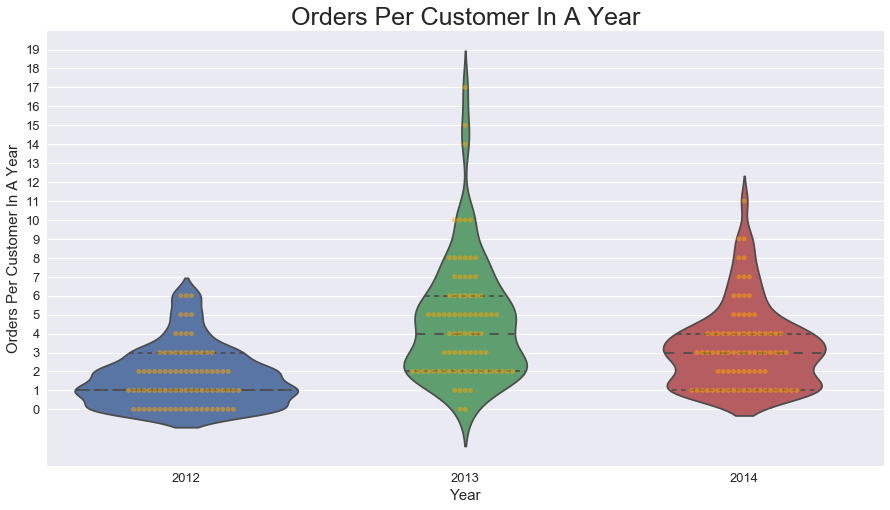

In [184]:
data =[]
data += [('2012', o) for o in customer_history.Order_Counts_2]
data += [('2013', o) for o in customer_history.Order_Counts_1] 
data += [('2014', o) for o in customer_history.Order_Counts] 
# test[2013]=Total_per_Order[1].reset_index()
# test[2014]=Total_per_Order[2].reset_index()
data =pd.DataFrame(data)
data.columns =['Year','Orders']

fig, ax = plt.subplots(figsize=(15,8))

sns.violinplot(
    y="Orders", 
    x="Year", 
    data=data, 
    ax=ax,
#     color='aqua',
    inner="quartile",  # Seeing the mean and quariles
    bw=.3              # How much smoothing do we usec
)
sns_plot = sns.swarmplot(ax=ax, x="Year", y="Orders", data=data, color='orange', alpha=0.5, size=5)
plt.yticks(np.arange(0, 20, step=1), fontsize = 13)
ax.tick_params(axis='both', which='major', labelsize=13)
plt.ylabel('Orders per customer in a year'.title(), fontsize = 15)
plt.xlabel('Year',fontsize =15)
plt.title('Orders per customer in a year'.title(), fontsize = 25)


# fig.savefig('Orders_cust.png', dpi=400, bbox_inches="tight") #Saving fig

There are obvious outliers in the plot above so we check for quantile values and count outliers.

In [185]:
#Investigate Percentiles to find outliers 
for q in np.linspace(0.8,1,num=21):
    q2012 = round(customer_history.Order_Counts_2.quantile(q=q),2)
    q2013 = round(customer_history.Order_Counts_1.quantile(q=q),2)
    q2014 = round(customer_history.Order_Counts.quantile(q=q),2)
    print('{}th percentile:\t2012:{}\t2013:{}\t2014:{}'.format(round(q,2), q2012, q2013,q2014 ))

0.8th percentile:	2012:3.0	2013:7.0	2014:5.0
0.81th percentile:	2012:3.0	2013:7.0	2014:5.0
0.82th percentile:	2012:3.0	2013:7.0	2014:5.0
0.83th percentile:	2012:3.0	2013:7.0	2014:5.0
0.84th percentile:	2012:3.0	2013:7.2	2014:5.0
0.85th percentile:	2012:3.0	2013:8.0	2014:5.0
0.86th percentile:	2012:3.0	2013:8.0	2014:5.8
0.87th percentile:	2012:3.0	2013:8.0	2014:6.0
0.88th percentile:	2012:3.4	2013:8.0	2014:6.0
0.89th percentile:	2012:4.0	2013:8.0	2014:6.0
0.9th percentile:	2012:4.0	2013:8.0	2014:6.0
0.91th percentile:	2012:4.0	2013:8.0	2014:6.8
0.92th percentile:	2012:4.0	2013:9.2	2014:7.0
0.93th percentile:	2012:4.4	2013:10.0	2014:7.0
0.94th percentile:	2012:5.0	2013:10.0	2014:7.2
0.95th percentile:	2012:5.0	2013:10.0	2014:8.0
0.96th percentile:	2012:5.0	2013:10.0	2014:8.0
0.97th percentile:	2012:5.6	2013:12.4	2014:8.6
0.98th percentile:	2012:6.0	2013:14.4	2014:9.0
0.99th percentile:	2012:6.0	2013:15.4	2014:9.4
1.0th percentile:	2012:6.0	2013:17.0	2014:11.0


In [186]:
# sum(data.Orders>10)
customer_history.loc[customer_history.Order_Counts_1>10]

,CustomerId,Year_Order,Order_Counts,Total$,Year_Order_1,Order_Counts_1,Total$_1,Year_Order_2,Order_Counts_2,Total$_2
18,ERNSH,2014,9,42598.90,2013.0,15.0,56303.43,2012.0,6.0,21487.76
53,QUICK,2014,8,40526.99,2013.0,14.0,65762.45,2012.0,6.0,15910.30
61,SAVEA,2014,11,42806.25,2013.0,17.0,62658.55,2012.0,3.0,15254.05


We drop these three observations and conduct the ANOVA test.

In [187]:
drop_rows =customer_history[customer_history.Order_Counts_1>10].index
customer_history_filtered =customer_history.drop(drop_rows)

Text(0.5, 1.0, 'The Distiribution Of Orders Per Customer In A Year')

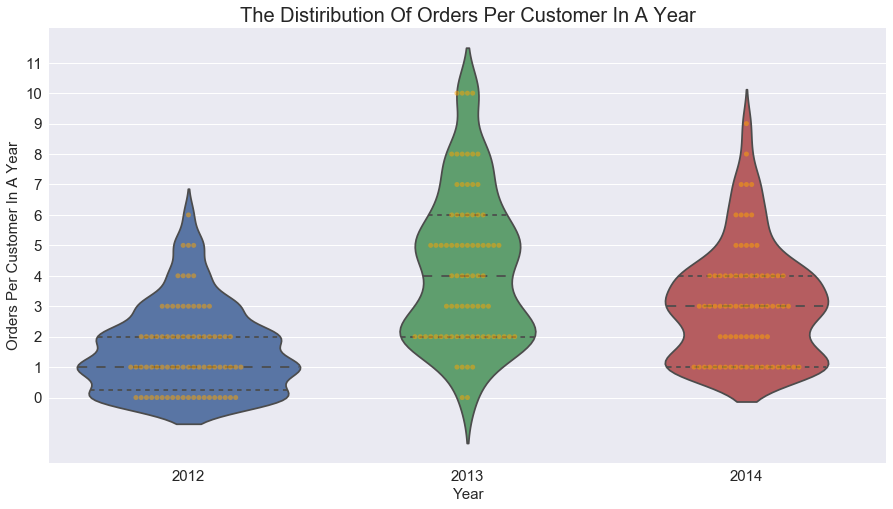

In [188]:
data =[]
data += [('2012', o) for o in customer_history_filtered.Order_Counts_2]
data += [('2013', o) for o in customer_history_filtered.Order_Counts_1] 
data += [('2014', o) for o in customer_history_filtered.Order_Counts] 
# test[2013]=Total_per_Order[1].reset_index()
# test[2014]=Total_per_Order[2].reset_index()
data =pd.DataFrame(data)
data.columns =['Year','Orders']

fig, ax = plt.subplots(figsize=(15,8))

sns.violinplot(
    y="Orders", 
    x="Year", 
    data=data, 
    ax=ax,
#     color='aqua',
    inner="quartile",  # Seeing the mean and quariles
    bw=.3              # How much smoothing do we usec
)
sns_plot = sns.swarmplot(ax=ax, x="Year", y="Orders", data=data, color='orange', alpha=0.5, size=5)
plt.ylabel('Orders per customer in a year'.title(),fontsize = 15)
plt.xlabel('Year',fontsize =15, rotation =0)
plt.yticks(np.arange(0, 12, step=1))
ax.tick_params(axis='both', which='major', labelsize=15)
plt.title('The distiribution of orders per customer in a year'.title(), fontsize =20)

 
# fig.savefig('Orders_cust_filtered.png', dpi=400, bbox_inches="tight") #Saving fig

Text(0.5, 1.0, 'The Distiribution Of Orders Per Customer In A Year')

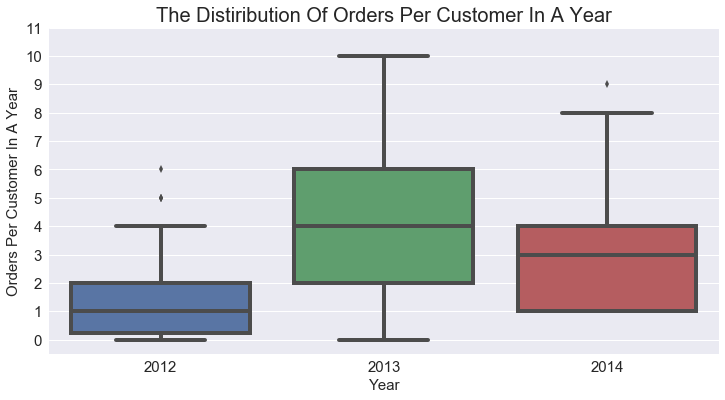

In [189]:
fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(
    y="Orders", 
    x="Year", 
    data=data, 
    ax=ax,
    #color='aqua',
    linewidth = 4, 
)

plt.ylabel('Orders per customer in a year'.title(),fontsize = 15)
plt.xlabel('Year',fontsize =15, rotation =0)
plt.yticks(np.arange(0, 12, step=1))
ax.tick_params(axis='both', which='major', labelsize=15)
plt.title('The distiribution of orders per customer in a year'.title(), fontsize =20)


# fig.savefig('box_Orders_cust_filtered.png', dpi=400, bbox_inches="tight") #Saving fig

First, let us compare all three years.

$H_0$ : The average number of orders per customer in year 2012, 2013, and 2014 ($\mu_{2012}$, $\mu_{2013}$, $\mu_{2014}$) has not changed.

$$ \large\mu_{2012} = \mu_{2013} = \mu_{2014}$$

$H_a$ : The average number of order per customer are different from one year to the others (at least one of them is different from the other two averages). 

* Conducting the test with outliers

In [190]:
compare={}
compare['2012']=customer_history.Order_Counts_2
compare['2013']=customer_history.Order_Counts_1
compare['2014']=customer_history.Order_Counts
f_test_p =stats.f_oneway(compare['2012'], compare['2013'],compare['2014'])[1]
anova_oneway_summary(compare,'the mean numbers of orders per customer', f_test_p ,alpha =0.05)
stats.f_oneway(customer_history.Order_Counts_2, customer_history.Order_Counts_1,customer_history.Order_Counts)[1]

Comparison of the averages of the mean numbers of orders per customer for 2012, 2013, and 2014.
Median Values:	2012:1.0	2013:4.0	2014:3.0
Mean Values:	2012:1.73	2013:4.69	2014:3.33
Sample sizes:	2012:81	2013:81	2014:81


ANOVA test p-value:0.0
Test result:	There is statistically significant difference 
 		between the means of two groups with 95.0% confidence level.


2.2628088845470253e-12

* Conducting the test WITHOUT outliers

In [191]:
compare={}
compare['2012']=customer_history_filtered.Order_Counts_2
compare['2013']=customer_history_filtered.Order_Counts_1
compare['2014']=customer_history_filtered.Order_Counts
f_test_p =stats.f_oneway(compare['2012'], compare['2013'],compare['2014'])[1]
anova_oneway_summary(compare,'the mean numbers of orders per customer', f_test_p ,alpha =0.05)
stats.f_oneway(customer_history_filtered.Order_Counts_2, customer_history_filtered.Order_Counts_1,customer_history_filtered.Order_Counts)[1]

Comparison of the averages of the mean numbers of orders per customer for 2012, 2013, and 2014.
Median Values:	2012:1.0	2013:4.0	2014:3.0
Mean Values:	2012:1.6	2013:4.28	2014:3.1
Sample sizes:	2012:78	2013:78	2014:78


ANOVA test p-value:0.0
Test result:	There is statistically significant difference 
 		between the means of two groups with 95.0% confidence level.


3.0378619107107566e-14

Now, we see the change in the average number of orders from 2013 to 2014. 

$H_0$ : The average number of orders per customer in year 2013 and 2014 ( $\mu_{2013}$, $\mu_{2014}$) has not changed.

$$ \mu_{2013} \le \mu_{2014}$$

$H_a$ : The average number of orders per customer decreased from 2013 to 2014 . 
$$ \mu_{2013} > \mu_{2014}$$

* With outliers

In [192]:
compare = {}
compare['2013']=customer_history.Order_Counts_1
compare['2014']=customer_history.Order_Counts
welch_summary(compare, 'total number of orders per year ')

Comparison of the average of total number of orders per year  for 2013 and 2014
Median Values: 	2013:4.0 	2014:3.0
Mean Values: 	2013:4.69 	2014:3.33
Sample sizes: 	2013:81 	2014:81


Welch's t-test p-value:0.00109
Test result:	There is statistically significant difference 
 		between the means of two groups with 95.0% confidence level.
Effect size:	0.49
Level of effect size:	small




(0.00109, 0.49)

* WITHOUT outliers

In [193]:
compare = {}
compare['2013']=customer_history_filtered.Order_Counts_1
compare['2014']=customer_history_filtered.Order_Counts
welch_summary(compare, 'total number of orders per year ')

Comparison of the average of total number of orders per year  for 2013 and 2014
Median Values: 	2013:4.0 	2014:3.0
Mean Values: 	2013:4.28 	2014:3.1
Sample sizes: 	2013:78 	2014:78


Welch's t-test p-value:0.00054
Test result:	There is statistically significant difference 
 		between the means of two groups with 95.0% confidence level.
Effect size:	0.53
Level of effect size:	medium




(0.00054, 0.53)

Note that the Cohen's d value became larger after filtering outliers which is in medium level of effect size. So the difference in number of orders per customer from 2013 to 2014 is significant and the decrease in the number of orders is in the medium level. 

# Quantity per order depending on positions of employees (managers vs. sales rep.)

In [194]:
query  = """SELECT o.*, od.*, p.*, c.*,
                    e.Id, e.LastName, e.FirstName, e.Title, e.HireDate, e.Region
             FROM [Order] AS o
             JOIN OrderDetail AS od ON (o.Id== od.OrderId)
             JOIN Employee AS e ON (o.EmployeeId = e.Id)
             JOIN Product AS p ON(od.ProductId = p.Id)
             JOIN Customer AS c on (o.CustomerId = c.Id)"""

employee_effect = pd.read_sql(query,conn)
employee_effect.columns = rename_dup_columns(employee_effect)

There are 5 columns with name:Id
There are 2 columns with name:UnitPrice
There are 2 columns with name:Region


C:\Users\woogu\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  from ipykernel import kernelapp as app
C:\Users\woogu\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: 'get_duplicates' is deprecated and will be removed in a future release. You can use idx[idx.duplicated()].unique() instead
  app.launch_new_instance()


Text(0.5, 1.0, 'Comparison Of Order Counts By Year')

<Figure size 432x288 with 0 Axes>

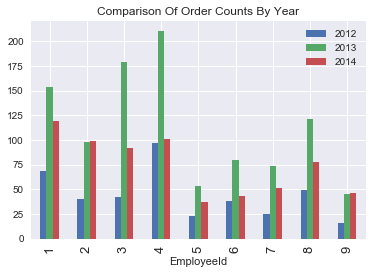

In [195]:
employee_effect['Year_Order'] = [int(x[:4]) for x in employee_effect.OrderDate]
Order_count = employee_effect.groupby(['Year_Order','EmployeeId']).count().OrderId
order_count_df =pd.DataFrame({2012:Order_count[2012], 
                              2013:Order_count[2013], 
                              2014:Order_count[2014]})
fig = plt.figure()
order_count_df.plot.bar()
plt.title('Comparison of order counts by year'.title())


# fig.savefig('OrderCount_empl.png', dpi=400, bbox_inches="tight") #Saving fig

In [196]:
titles={}
for Id in employee_effect.EmployeeId.unique():
    titles[Id] = employee_effect.loc[employee_effect['EmployeeId'] == Id].Title.unique()[0]
sorted_titles = sorted(titles.items(), key = lambda kv:kv[0])
# pd.DataFrame(titles, index = titles.keys(), column =)


In [197]:
sorted_titles

[(1, 'Sales Representative'),
 (2, 'Vice President, Sales'),
 (3, 'Sales Representative'),
 (4, 'Sales Representative'),
 (5, 'Sales Manager'),
 (6, 'Sales Representative'),
 (7, 'Sales Representative'),
 (8, 'Inside Sales Coordinator'),
 (9, 'Sales Representative')]

As decrease in sales made by each employee by years seem varied, average quantity per order was compared between two groups; managerial groups and sales rep. group. 

In [198]:
#collection of manager group data
manager1 = employee_effect.loc[employee_effect.EmployeeId ==2]
manager2 = employee_effect.loc[employee_effect.EmployeeId ==5]
manager3 = employee_effect.loc[employee_effect.EmployeeId ==8]
manager = pd.concat([manager1,manager2,manager3])

In [199]:
#collection of sales rep. group data
rep =[]
repId =[1,3,4,6,7,9]
for Id in repId:
    rep.append(employee_effect.loc[employee_effect.EmployeeId ==Id])

salesRep= pd.concat(rep)

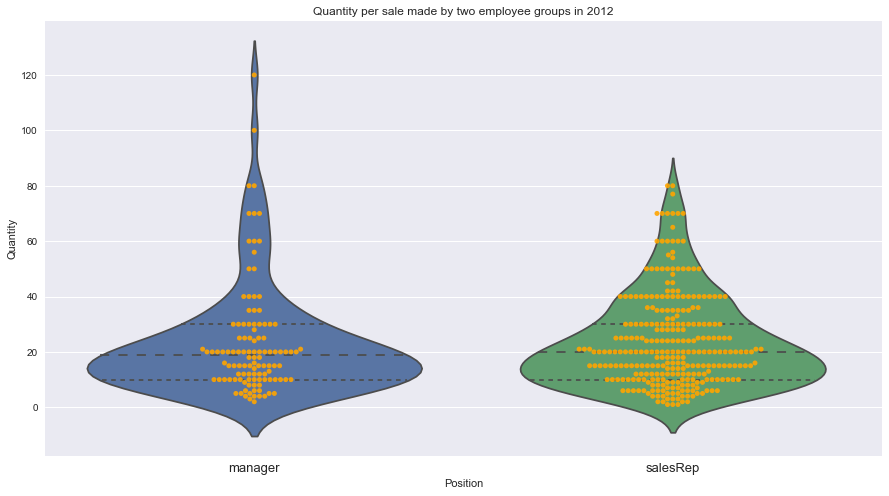

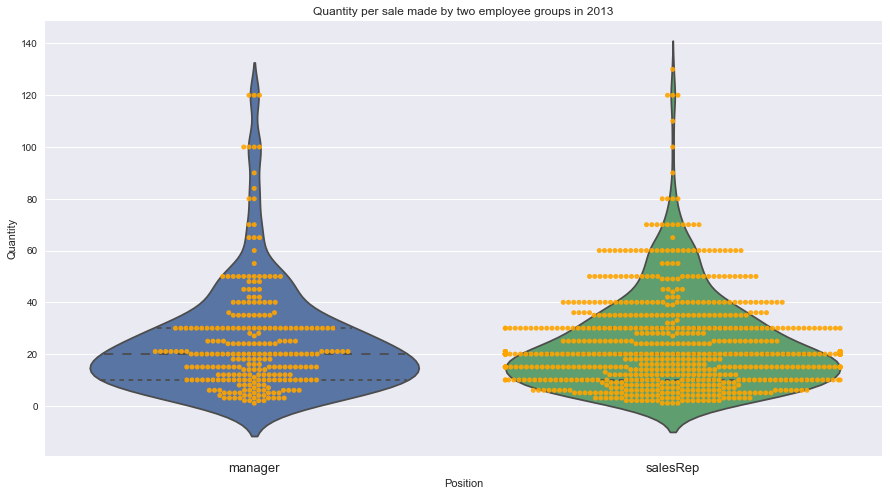

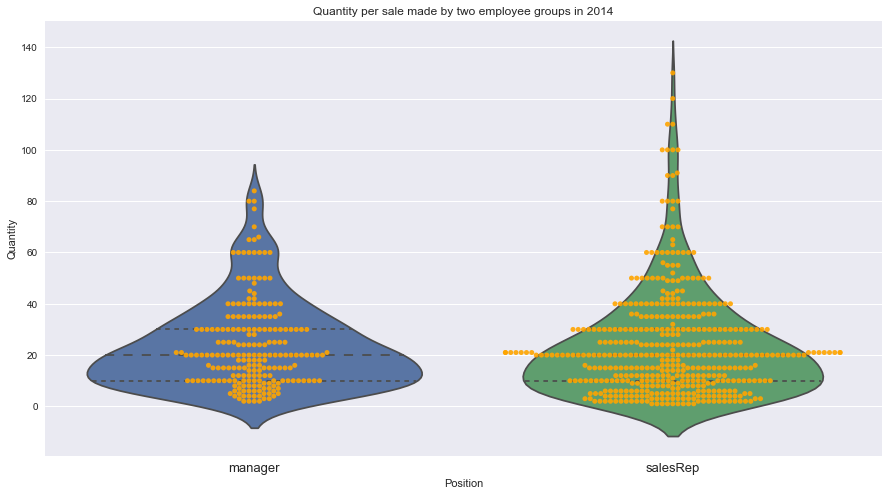

In [200]:
for year in [2012,2013,2014]:
    data =[]
    data += [('manager', o) for o in manager.loc[manager['Year_Order']==year].Quantity]
    data += [('salesRep', o) for o in salesRep.loc[salesRep['Year_Order']==year].Quantity] 


    # test[2013]=Total_per_Order[1].reset_index()
    # test[2014]=Total_per_Order[2].reset_index()
    data =pd.DataFrame(data)
    data.columns =['Position','Quantity']

    fig, ax = plt.subplots(figsize=(15,8))

    sns.violinplot(
        y="Quantity", 
        x="Position", 
        data=data, 
        ax=ax,
#         color='aqua',
        inner="quartile",  # Seeing the mean and quariles
        bw=.3              # How much smoothing do we usec
    )
    sns_plot = sns.swarmplot(ax=ax, x="Position", y="Quantity", data=data, color='orange', alpha=0.9, size=5)
    plt.title(f'Quantity per sale made by two employee groups in {year}')


#     fig.savefig(f'Quant_sale_group{year}.png', dpi=400, bbox_inches="tight") #Saving fig


Text(0.5, 1.0, 'Quantity per sale made by two employee groups in 2014')

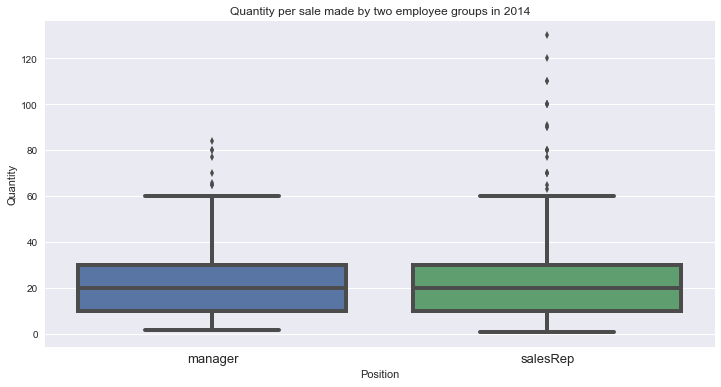

In [201]:
fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(
    y="Quantity", 
    x="Position",
    data=data, 
    ax=ax,
    #color='aqua',
    linewidth = 4, 
)


plt.title(f'Quantity per sale made by two employee groups in {year}')



# fig.savefig(f'Quant_sale_group{year}.png', dpi=400, bbox_inches="tight") #Saving fig


$H_0$ : The difference in the average quantity per sale made by two groups ( $\mu_{manager}$, $\mu_{saleRep}$) is insignificant.

$$ \mu_{manager} = \mu_{saleRep}$$

$H_a$ : The difference in the average quantity per sale made by two groups is insignificant.
$$ \mu_{manager} \ne \mu_{saleRep}$$

We use two way welch's t-test and we conduct this test for each year.

In [202]:
for year in [2012,2013,2014]:
    a=list(manager.loc[manager.Year_Order==year].Quantity)
    b=list(salesRep.loc[salesRep.Year_Order==year].Quantity)
    compare = {'manager':manager.loc[manager.Year_Order==year].Quantity,
              'salesRep':salesRep.loc[salesRep.Year_Order==year].Quantity}
    measurement =' average quantity per sale by two different groups '
    f = stats.f_oneway(a,b)[1]
    anova_oneway_summary(compare,measurement, f,alpha =0.05)

Comparison of the averages of  average quantity per sale by two different groups  for manager, and salesRep.
Median Values:	manager:19.0	salesRep:20.0
Mean Values:	manager:23.41	salesRep:23.63
Sample sizes:	manager:112	salesRep:286


ANOVA test p-value:0.91282
Test result:	The differenc in mean values between groups is
 		statistically insignificant with 5.0% significance level.
Comparison of the averages of  average quantity per sale by two different groups  for manager, and salesRep.
Median Values:	manager:20.0	salesRep:20.0
Mean Values:	manager:24.86	salesRep:24.06
Sample sizes:	manager:272	salesRep:742


ANOVA test p-value:0.55355
Test result:	The differenc in mean values between groups is
 		statistically insignificant with 5.0% significance level.
Comparison of the averages of  average quantity per sale by two different groups  for manager, and salesRep.
Median Values:	manager:20.0	salesRep:20.0
Mean Values:	manager:23.79	salesRep:23.52
Sample sizes:	manager:214	salesRep:452


AN

# Influence of discounts on sales

In [203]:
df_tables['OrderDetail'].Discount.unique()

array([0.  , 0.15, 0.05, 0.2 , 0.25, 0.1 , 0.02, 0.03, 0.04, 0.06, 0.01])

In [204]:
query = """ SELECT DISTINCT(Discount) FROM OrderDetail ORDER BY Discount DESC"""
perc_disc = pd.read_sql(query,conn).Discount

In [205]:
subsets ={}
for disc in perc_disc:
    percent = int(disc*100)
    subsets[percent] = df[df.Discount == disc].Quantity
    subsets[percent] = subsets[percent].reset_index().drop('index', axis =1)
    print(f'number of sales with {percent}% discount :', len(subsets[percent]))
    

number of sales with 25% discount : 154
number of sales with 20% discount : 161
number of sales with 15% discount : 157
number of sales with 10% discount : 173
number of sales with 6% discount : 1
number of sales with 5% discount : 185
number of sales with 4% discount : 1
number of sales with 3% discount : 3
number of sales with 2% discount : 2
number of sales with 1% discount : 1
number of sales with 0% discount : 1317


C:\Users\woogu\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


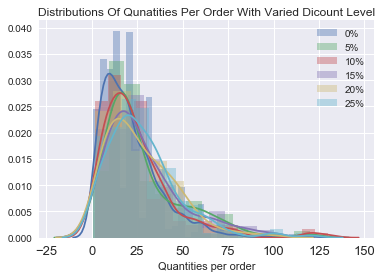

In [206]:
percents_testing = list(range(0,30,5))
for percent in percents_testing:
    lab =str(percent)+'%'
    sns_plot =sns.distplot(subsets[percent], label = lab)
    plt.xlabel('Quantities per order')
    plt.legend()
    plt.title('Distributions of Qunatities per order with varied dicount level'.title())

# fig1 = sns_plot.get_figure() #saving figures
# fig1.savefig(f'Quant_order_discount.png', dpi=400, bbox_inches="tight") #Saving fig


Text(0.5, 1.0, 'The Distiribution Of Quantities Per Order With Discounts')

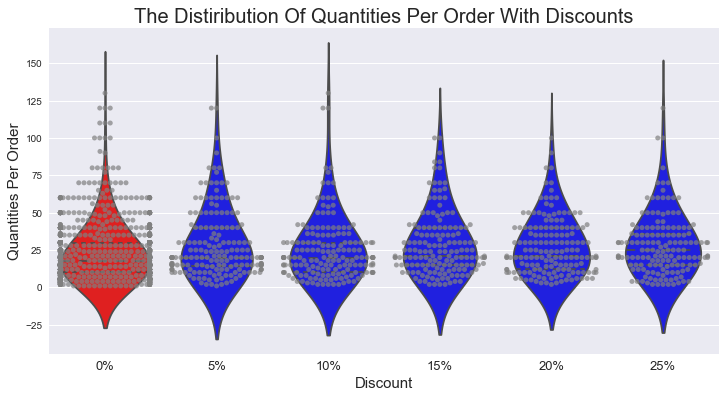

In [207]:
data =[]
data += [('0%', o) for o in subsets[0].Quantity]
data += [('5%', o) for o in subsets[5].Quantity] 
data += [('10%', o) for o in subsets[10].Quantity] 
data += [('15%', o) for o in subsets[15].Quantity] 
data += [('20%', o) for o in subsets[20].Quantity] 
data += [('25%', o) for o in subsets[25].Quantity]  
# test[2013]=Total_per_Order[1].reset_index()
# test[2014]=Total_per_Order[2].reset_index()
data =pd.DataFrame(data)
data.columns =['Discount','Quantity']

fig, ax = plt.subplots(figsize=(12,6))

my_pal = {discount: "r" if discount == "0%" else "b" for discount in data.Discount.unique()}
 

sns.violinplot(
    y="Quantity", 
    x="Discount", 
    data=data, 
    ax=ax,
    palette = my_pal,
#     color='aqua',
    inner="quartile",  # Seeing the mean and quariles
    bw=.8              # How much smoothing do we usec
)
sns_plot = sns.swarmplot(ax=ax, x="Discount", y="Quantity", data=data, color='grey', alpha=0.7, size=5)
plt.ylabel('Quantities per order'.title(), fontsize =15)
plt.xlabel('Discount', fontsize =15)
plt.rc('xtick', labelsize = 13)
plt.rc('ytick', labelsize = 13)
plt.title('The distiribution of quantities per order with discounts'.title(), fontsize =20)


# fig.savefig(f'violin_Quant_sale_group.png', dpi=400, bbox_inches="tight") #Saving fig


Text(0.5, 1.0, 'The Distiribution Of Quantities Per Order With Discounts')

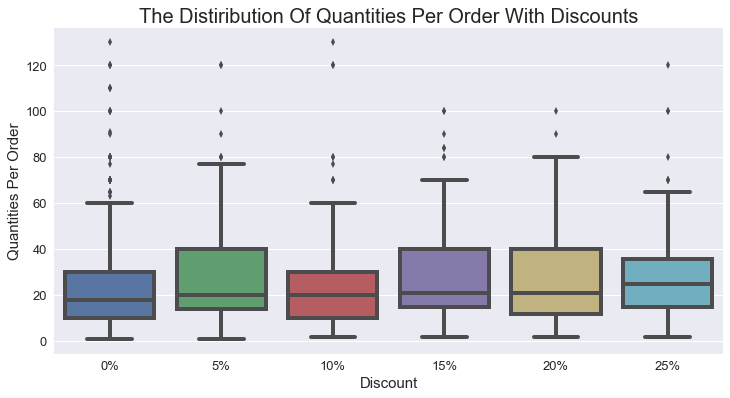

In [208]:
fig, ax = plt.subplots(figsize=(12,6))
sns.boxplot(
    y="Quantity", 
    x="Discount", 
    data=data, 
    ax=ax,
    #color='aqua',
    linewidth = 4, 
)


plt.title(f'Quantity per sale made by two employee groups in {year}')
plt.ylabel('Quantities per order'.title(), fontsize =15)
plt.xlabel('Discount', fontsize =15)
plt.rc('xtick', labelsize = 13)
plt.rc('ytick', labelsize = 13)
plt.title('The distiribution of quantities per order with discounts'.title(), fontsize =20)


# fig.savefig(f'box_discount.png', dpi=400, bbox_inches="tight") #Saving fig



The distributions look very similar to each other from no discount to 5 different discount levels. 

So we want to conduct an ANOVA test to check if the difference in mean values ($\mu_{10\%}$, $\mu_{5\%}$, $\mu_{10\%}$, $\mu_{15\%}$, $\mu_{20\%}$, $\mu_{25\%}$) of quantities sold with and without discount is insignificant.  
Null hypothesis($H_0$):
$$\Large\mu_{0\%} = \mu_{5\%} = \mu_{10\%} = \mu_{15\%} = \mu_{20\%} =\mu_{25\%}$$ 

In [209]:
discounts = percents_testing[1:]
no_disc = subsets[0].Quantity
compare ={}
compare['0%'] = no_disc
compare_list = [no_disc]
for discount in discounts:
    disc = subsets[discount].Quantity
    compare[str(discount)+'%'] =disc
    compare_list.append(disc)
f_test_p = stats.f_oneway(compare_list[0], compare_list[1],compare_list[2], compare_list[3], compare_list[4],compare_list[5])[1]
anova_oneway_summary(compare,'the average quantities per order with discounts', f_test_p ,alpha =0.05)

Comparison of the averages of the average quantities per order with discounts for 0%, 5%, 10%, 15%, 20%, and 25%.
Median Values:	0%:18.0	5%:20.0	10%:20.0	15%:21.0	20%:21.0	25%:25.0
Mean Values:	0%:21.72	5%:28.01	10%:25.24	15%:28.38	20%:27.02	25%:28.24
Sample sizes:	0%:1317	5%:185	10%:173	15%:157	20%:161	25%:154


ANOVA test p-value:0.0
Test result:	There is statistically significant difference 
 		between the means of two groups with 95.0% confidence level.


0.0

The graph above shows that the highest peak (mean) of plots shift slightly right as the discount increases. 

We want to test the differences in means between no discount and varied discount levels are statistically significant. 
Let us name the group of orders with no discount as control set and its mean in quantity per order as $\mu_0$. Then name the groups with different  discount levels (5% ~ 25%) as experimental set and their means as $\mu_1$.

We want to conduct one-sided Welch's t-test as:
* we compare two independent sets with different sizes and variances; 
* we expect the discount would encourage customers to buy more not less. 

Null hypothesis($H_0$):

$$\Large\mu_1 \le \mu_0$$ 

Alternative hypothesis($H_a$):

$$\Large\mu_1 > \mu_0$$

In [210]:
discounts = percents_testing[1:]
no_disc = subsets[0].Quantity
for discount in discounts:
    disc = subsets[discount].Quantity
    compare={str(discount)+'%':disc,'0%':no_disc}
    welch_summary(compare,'means in quantities of an order', two_sided = False)


Comparison of the average of means in quantities of an order for 5% and 0%
Median Values: 	5%:20.0 	0%:18.0
Mean Values: 	5%:28.01 	0%:21.72
Sample sizes: 	5%:185 	0%:1317


Welch's t-test p-value:0.00014
Test result:	There is statistically significant difference 
 		between the means of two groups with 95.0% confidence level.
Effect size:	0.35
Level of effect size:	small


Comparison of the average of means in quantities of an order for 10% and 0%
Median Values: 	10%:20.0 	0%:18.0
Mean Values: 	10%:25.24 	0%:21.72
Sample sizes: 	10%:173 	0%:1317


Welch's t-test p-value:0.01873
Test result:	There is statistically significant difference 
 		between the means of two groups with 95.0% confidence level.
Effect size:	0.2
Level of effect size:	small


Comparison of the average of means in quantities of an order for 15% and 0%
Median Values: 	15%:21.0 	0%:18.0
Mean Values: 	15%:28.38 	0%:21.72
Sample sizes: 	15%:157 	0%:1317


Welch's t-test p-value:9e-05
Test result:	There is statistically 

In [211]:
effect_sizes ={}
# m0 = no_disc.mean().reset_index()[0][0]
# std0 = no_disc.std().reset_index()[0][0]
for discount in discounts:
#     m1 = subsets[discount].mean().reset_index()[0][0]
    effect = Cohen_d(subsets[discount],no_disc)
    effect_sizes[discount]=effect

Text(0, 0.5, 'Effect Sizes')

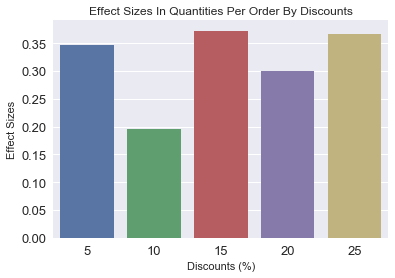

In [212]:
sns_plot = sns.barplot(x=discounts, y=list(effect_sizes.values()))
plt.title('Effect sizes in quantities per order by discounts'.title())
plt.xlabel('discounts (%)'.title())
plt.ylabel("effect sizes".title())

# fig1 = sns_plot.get_figure() #saving figures
# fig1.savefig(f'effect_discount.png', dpi=400, bbox_inches="tight") #Saving fig


The effect sizes in quantities of products per order by discounts are small. 
Sales with small discounts result in quantity changes in orders as the one with larger discounts. With 5% discounts, about 15% of a group is estimated to order more ( about 6 more units)

https://rpsychologist.com/d3/cohend/

# Suggestions for further investigation

## Sales by categories
Beberages and produce categories has less decrease in sales in 2014 than other categories. 
It is recommended to investigate what made sales these categories different than others.

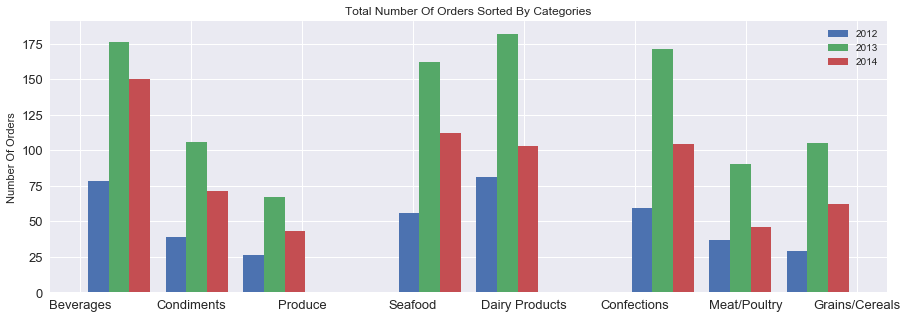

In [213]:
Orders_by_Year = []

for i, year in enumerate(df.Year_Order.unique()):
    Orders_by_Year.append(df[df.Year_Order == year].CategoryName) 
fig = plt.figure(figsize =(15,5))
plt.hist(Orders_by_Year, label =['2012', '2013','2014'])
plt.ylabel('number of orders'.title())
plt.title('Total number of orders sorted by categories'.title())
plt.legend()
plt.show()

## Sales by regional offices 

In [214]:
def sum_sales_grouped_by_employee_year(year):
    """Compute total sales counts for varied shipping regions 
        made by two regional offices
        Take: year in interger
        Return: dictionary with
                    key as the region of the office
                    value as the total sale in each region"""
    by_year = employee_effect.loc[employee_effect.Year_Order == year]

    ship_region_list =np.array([0]*len(employee_effect.ShipRegion.unique()))
    ship_region_list = pd.Series(ship_region_list)
    ship_region_list.index =employee_effect.ShipRegion.unique()

    employee_region ={}
    for region in by_year.Region_1.unique():
        employee_region[region] = ship_region_list

    for e_id in by_year.EmployeeId.unique():
        a = by_year.loc[by_year.EmployeeId == e_id].ShipRegion.value_counts()
    #     print(a)
        for region in ship_region_list.index:
            if region not in a.index:
                a[region] = 0

        if by_year.loc[(by_year.EmployeeId==e_id)].Region_1.unique()[0] == 'British Isles':
            employee_region['British Isles'] = employee_region['British Isles']+ a
        else:
            employee_region['North America'] = employee_region['North America'] + a
    return(employee_region)

Text(0.5, 0.98, 'The Orders In Different Regions Between Two Offices')

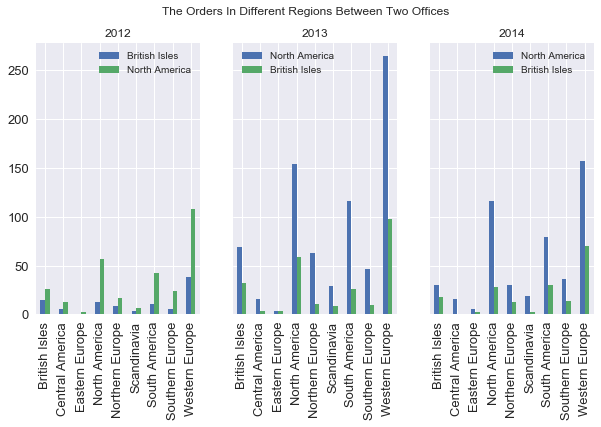

In [215]:
fig, axs = plt.subplots(1,3, figsize = (10,5),sharey=True)
pd.DataFrame(sum_sales_grouped_by_employee_year(2012)).plot(kind ='bar',ax =axs[0])
axs[0].set_title('2012')
pd.DataFrame(sum_sales_grouped_by_employee_year(2013)).plot(kind ='bar',ax =axs[1])
axs[1].set_title('2013')
pd.DataFrame(sum_sales_grouped_by_employee_year(2014)).plot(kind ='bar',ax =axs[2])
axs[2].set_title('2014')
fig.suptitle('The orders in different regions between two offices'.title())


# fig.savefig(f'order_region_office.png', dpi=400, bbox_inches="tight") #Saving fig


Text(0.5, 1.0, 'British Isles Office')

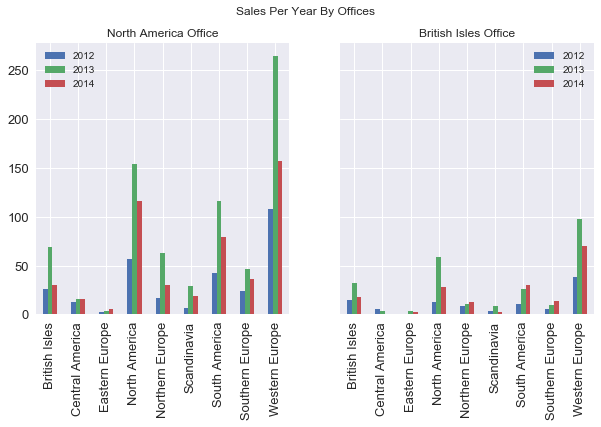

In [216]:
USoffice_year ={}
ENoffice_year ={}
for i in [2012,2013,2014]:
    USoffice_year[i]= sum_sales_grouped_by_employee_year(i)['North America']
    ENoffice_year[i]= sum_sales_grouped_by_employee_year(i)['British Isles']
USoffice_year = pd.DataFrame(USoffice_year)
ENoffice_year = pd.DataFrame(ENoffice_year)
fig, axs = plt.subplots(1,2, figsize = (10,5),sharey=True)
USoffice_year.plot(kind = 'bar', ax= axs[0])
fig.suptitle('Sales per year by offices'.title())
axs[0].set_title('North America Office')
ENoffice_year.plot(kind = 'bar', ax= axs[1])
axs[1].set_title('British Isles Office')

# fig.savefig('order_region_office2.png', dpi=400, bbox_inches="tight") #Saving fig


## Sales by regions

* Total sales by regions

Text(0.5, 0, 'Region')

<Figure size 432x288 with 0 Axes>

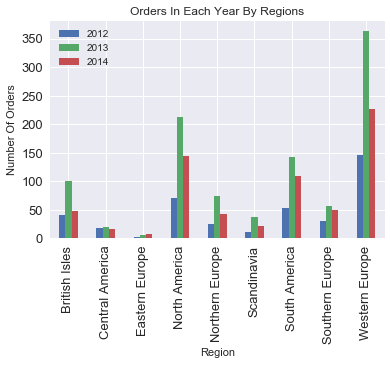

In [217]:
sales_by_shippingRegion ={}
for i in [2012,2013,2014]:
    sales_by_shippingRegion[i]=sum(sum_sales_grouped_by_employee_year(i).values())
a = sales_by_shippingRegion
fig = plt.figure()
pd.DataFrame(a).plot.bar()
plt.title('Orders in each year by regions'.title())
plt.ylabel('number of orders'.title())
plt.xlabel('region'.title())

# fig.savefig(f'order_region.png', dpi=400, bbox_inches="tight") #Saving fig


## Sales by suppliers

<Figure size 432x288 with 0 Axes>

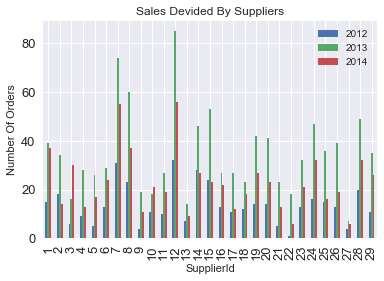

In [218]:
### counting orders by supplier Id
q = """ SELECT SupplierId, COUNT(OrderId) as [2012]
        FROM employee_effect WHERE Year_Order = 2012
        GROUP BY 1"""
supplier12 = pysqldf(q)
q = """ SELECT SupplierId, COUNT(OrderId) as [2013]
        FROM employee_effect WHERE Year_Order = 2013
        GROUP BY 1"""
supplier13 = pysqldf(q)
q = """ SELECT SupplierId, COUNT(OrderId) as [2014]
        FROM employee_effect WHERE Year_Order = 2014
        GROUP BY 1"""
supplier14 = pysqldf(q)
supplier = supplier12.set_index('SupplierId').join(supplier13.set_index('SupplierId')).join(supplier14.set_index('SupplierId'))

fig = plt.figure()
supplier.plot.bar()
plt.title('Sales devided by Suppliers'.title())
plt.ylabel('number of orders'.title())
plt.show()
# fig.savefig('suppliers.png',dpi=400, bbox_inches="tight")#saving fig